# Analysis 2.1
- Outcome: CGC in 3 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [71]:
%load_ext rpy2.ipython 
# Load the R magic extension

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [72]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [73]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [74]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [75]:
%%R
source("utils.R")
library(survival)

In [76]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [108]:
model = 'logreg'
cancer = 'CGC'
ro.globalenv['model'] = model
ro.globalenv['cancer'] = cancer

analysis_num = '2.1'

In [ ]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [109]:
%%R 
outcome_interval <- "_3yr"
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), outcome_interval)
model_filename <- paste0(model, "_", outcome_event, ".rds")

In [ ]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
outcome_event = r['outcome_event'][0]
outcome_interval = r['outcome_interval'][0]

In [ ]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [81]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [82]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [83]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [84]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [85]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000004,0.000001,0.000010,5.742708e-135
1,sex_missing.sex_missingMALE,sex_missing,MALE,3.181722,1.088028,11.480866,4.744453e-02
2,race_clean.(Intercept),race_clean,(Intercept),0.000014,0.000007,0.000025,4.888752e-247
5,race_clean.race_cleanNo matching concept,race_clean,No matching concept,0.194916,0.029715,0.756287,3.645423e-02
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000012,0.000006,0.000021,2.792966e-307
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.125694,0.006876,0.646043,4.707610e-02
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000009,0.000005,0.000015,0.000000e+00
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000006,0.000003,0.000010,2.901707e-256
13,tobacco_binary.tobacco_binary1,tobacco_binary,1,3.812288,1.336631,10.621509,9.709178e-03
14,hpylori_active_chronic_binary.(Intercept),hpylori_active_chronic_binary,(Intercept),0.000009,0.000005,0.000014,0.000000e+00


## Feature selection

In [86]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "tobacco_binary" 
 [5] "hnca"            "cad"             "famhx_cancer"    "famhx_gastricca"
 [9] "PPI"             "age"            


### Forest plot for univariate visualization

In [87]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

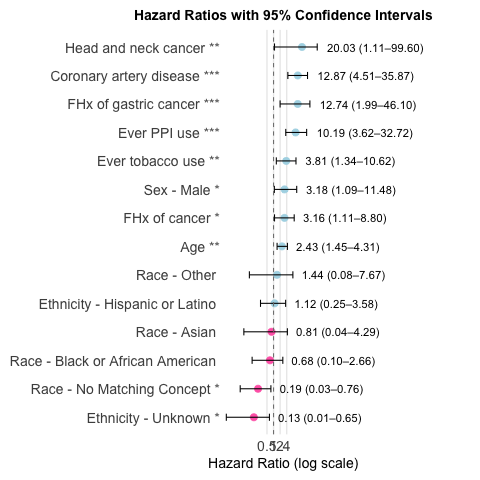

In [88]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [89]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 34168" "Dataset Cases 15"      
[1] "Training Controls 27336" "Training Cases 11"      
[1] "Validation Controls 6832" "Validation Cases 4"      



#### Multivariate analysis

In [90]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2_CGC.csv 


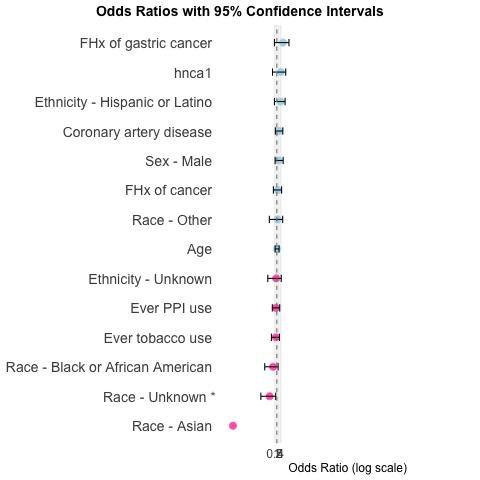

In [91]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [92]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [93]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [94]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.576 
Sensitivity: 0.5 
Specificity: 0.6995023 
PPV: 0.000973236 
NPV: 0.9995817 
NNS: 1802.083 
     predicted_class
event    0    1
    0 4779 2053
    1    2    2


### Sensitivity and Metrics at threshold that maximizes Youdens

In [95]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.576 
Sensitivity: 0.5 
Specificity: 0.8365047 
PPV: 0.00178731 
NPV: 0.9996502 
NNS: 695.6637 
     predicted_class
event    0    1
    0 5715 1117
    1    2    2


### AUROC curves and PR curve

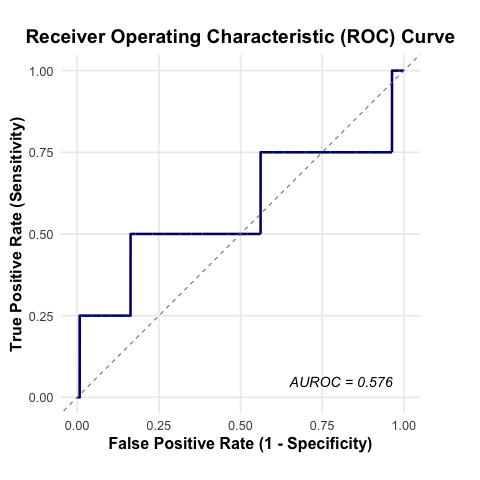

In [96]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

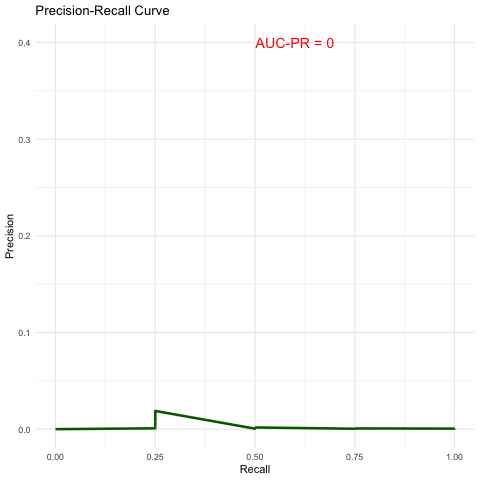

In [97]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [98]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [99]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.8363077823288472,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.149210,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000018,0.056905,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000350,0.646431,0.6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000086,0.322703,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000571,0.805442,0.8,1,1,1,1,1,0,0,0,0,0,0,0,0,0


In [102]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [103]:
df_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,cgc_3yr,70-79,1958,2,358,1 (0.3%),0.3,1,357,1,1601,0.817347,0.182653,50.000000,81.767109,0.279330,99.937578,461.025723,0.317671
71,high_risk_youden,youden,cgc_3yr,50-59,1270,1,174,1 (0.6%),0.6,1,173,0,1097,0.863887,0.136113,100.000000,86.377953,0.574713,100.000000,174.000000,0.863780
72,high_risk_youden,youden,cgc_3yr,2011-2014,2867,1,511,0 (0.0%),0.0,0,511,1,2356,0.821478,0.178522,0.000000,82.176491,0.000000,99.957573,-2357.000000,-0.178235
73,high_risk_youden,youden,cgc_3yr,2015-2018,2297,3,390,2 (0.5%),0.5,2,388,1,1909,0.830870,0.169130,66.666667,83.108402,0.512821,99.947644,217.172012,0.497751
74,high_risk_youden,youden,cgc_3yr,2019-2022,1668,0,218,0 (0.0%),0.0,0,218,0,1450,0.869305,0.130695,0.000000,86.930456,0.000000,100.000000,inf,-0.130695


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [104]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
60,high_risk_youden,youden,cgc_3yr,No matching concept,2337,1,22,1 (4.5%),4.5,1,21,0,2316,0.991018,0.008982,100.000000,99.101412,4.545455,100.000000,22.000000,0.991014
61,high_risk_youden,youden,cgc_3yr,White,2531,1,937,1 (0.1%),0.1,1,936,0,1595,0.630332,0.369668,100.000000,63.018570,0.106724,100.000000,937.000000,0.630186
62,high_risk_youden,youden,cgc_3yr,Black or African American,1475,1,36,0 (0.0%),0.0,0,36,1,1439,0.974932,0.025068,0.000000,97.559322,0.000000,99.930556,-1440.000000,-0.024407
63,high_risk_youden,youden,cgc_3yr,Asian,275,1,0,0 (nan%),NaN,0,0,1,275,0.996377,0.003623,0.000000,100.000000,0.000000,99.637681,NaN,0.000000
64,high_risk_youden,youden,cgc_3yr,Other,214,0,124,0 (0.0%),0.0,0,124,0,90,0.420561,0.579439,0.000000,42.056075,0.000000,100.000000,inf,-0.579439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_3yr,all,6818,18,684,6 (0.9%),0.9,6,678,12,6140,0.899064,0.100936,33.333333,90.055735,0.877193,99.804941,146.598662,0.233891
35,risk_p0.95,0.95,ugica_3yr,all,6818,18,340,4 (1.2%),1.2,4,336,14,6482,0.948800,0.051200,22.222222,95.071869,1.176471,99.784483,104.063325,0.172941
40,risk_p0.975,0.975,ugica_3yr,all,6818,18,171,2 (1.2%),1.2,2,169,16,6649,0.972937,0.027063,11.111111,97.521267,1.169591,99.759940,107.581178,0.086324
45,risk_p0.99,0.99,ugica_3yr,all,6818,18,68,2 (2.9%),2.9,2,66,16,6752,0.988005,0.011995,11.111111,99.031974,2.941176,99.763593,36.971722,0.101431


In [105]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [110]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [107]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    outcome_event: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
